In [1]:
from datasets import load_from_disk
from torchvision.transforms import Compose, Normalize, ToTensor
import torch
import torch.nn.functional as F
from diffusers import UNet2DModel, DDIMScheduler
from diffusers.optimization import get_scheduler
from diffusers.training_utils import EMAModel
from accelerate import Accelerator
import os
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from PIL import Image

/Users/jack/.virtualenvs/simple-audio-diffusion/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
# Accelerator params
GRADIENT_ACCUMULATION_STEPS=1
MIXED_PRECISION='no'
LOGGING_DIR='logs'

# dataset params
DATA_PATH='data/audio-diffusion-256'
BATCH_SIZE=10
NUM_TRAIN_STEPS=10

# optimizer params
LEARNING_RATE=1e-4
ADAM_BETA1=0.95
ADAM_BETA2=0.999
ADAM_WEIGHT_DECAY=1e-6
ADAM_EPSILON=1e-08

# lr_scheduler params
LR_SCHEDULER_TYPE='cosine'
LR_WARMUP_STEPS=50
NUM_EPOCHS=10

# EMAModel Params
USE_EMA=True
EMA_INV_GAMMA=1.0
EMA_POWER=3 /4
EMA_MAX_DECAY=0.99999

# training params
START_EPOCH=0

In [3]:
accelerator = Accelerator(
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    mixed_precision=MIXED_PRECISION,
    log_with="tensorboard",
    project_dir=LOGGING_DIR,
)

In [4]:
# load data set
dataset = load_from_disk(DATA_PATH)['train']

KeyError: 'images'

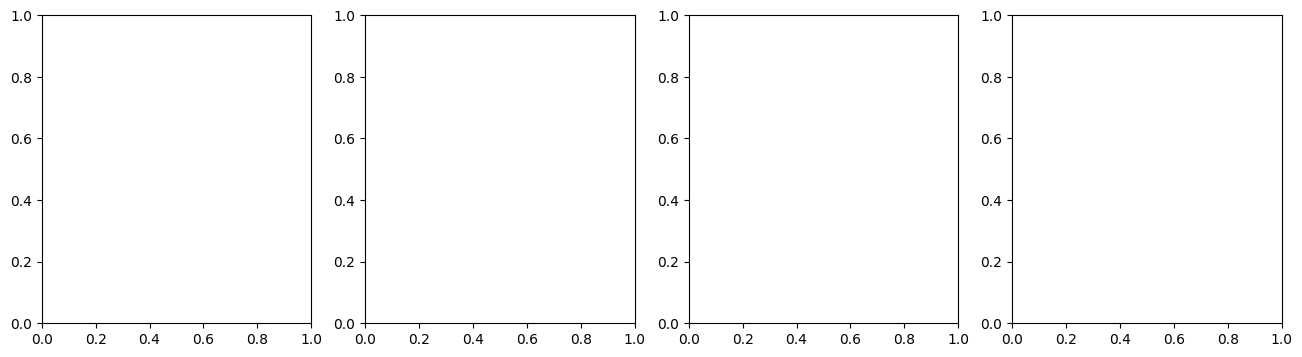

In [6]:
# plot a few spectrograms
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

for i, image in enumerate(dataset[:4]["images"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()

fig.show()

In [7]:
resolution = dataset[0]["image"].height, dataset[0]["image"].width

augmentations = Compose([
    ToTensor(),
    Normalize([0.5], [0.5]), # rescale pixels to b/t -1 and 1
])

def transforms(examples):
    images = [augmentations(image) for image in examples["image"]]
    return {"input": images}

# apply the augmentations() func on the fly during training
dataset.set_transform(transforms)

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [8]:
model = UNet2DModel(
    sample_size=resolution,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(128, 128, 256, 256, 512, 512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

In [9]:
# define scheduler
noise_scheduler = DDIMScheduler(num_train_timesteps=NUM_TRAIN_STEPS)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    betas=(ADAM_BETA1, ADAM_BETA2),
    weight_decay=ADAM_WEIGHT_DECAY,
    eps=ADAM_EPSILON,
)

lr_scheduler = get_scheduler(
    LR_SCHEDULER_TYPE,
    optimizer=optimizer,
    num_warmup_steps=LR_WARMUP_STEPS,
    num_training_steps=(len(train_dataloader) * NUM_EPOCHS) //
    GRADIENT_ACCUMULATION_STEPS,
)

model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
    model, optimizer, train_dataloader, lr_scheduler)


ema_model = EMAModel(
    getattr(model, "module", model),
    inv_gamma=EMA_INV_GAMMA,
    power=EMA_POWER,
    max_value=EMA_MAX_DECAY,
)

if accelerator.is_main_process:
    run = 'train'
    accelerator.init_trackers(run)

/Users/jack/.virtualenvs/simple-audio-diffusion/lib/python3.11/site-packages/diffusers/training_utils.py:73: FutureWarning: Passing a `torch.nn.Module` to `ExponentialMovingAverage` is deprecated. Please pass the parameters of the module instead.
  deprecate(
/Users/jack/.virtualenvs/simple-audio-diffusion/lib/python3.11/site-packages/diffusers/training_utils.py:86: FutureWarning: The `max_value` argument is deprecated. Please use `decay` instead.
  deprecate("max_value", "1.0.0", deprecation_message, standard_warn=False)


In [12]:
# training
global_step = 0
for epoch in range(NUM_EPOCHS):
    progress_bar = tqdm(total=len(train_dataloader),
                        disable=not accelerator.is_local_main_process)
    progress_bar.set_description(f"Epoch {epoch}")

    if epoch < START_EPOCH:
        for step in range(len(train_dataloader)):
            optimizer.step()
            lr_scheduler.step()
            progress_bar.update(1)
            global_step += 1
        if epoch == START_EPOCH - 1 and USE_EMA:
            ema_model.optimization_step = global_step
        continue

    model.train()
    for step, batch in enumerate(train_dataloader):
        clean_images = batch["input"]

        # Sample noise that we'll add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bsz = clean_images.shape[0]
        # Sample a random timestep for each image
        timesteps = torch.randint(
            0,
            noise_scheduler.config.num_train_timesteps,
            (bsz, ),
            device=clean_images.device,
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        # (this is the forward diffusion process)
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        with accelerator.accumulate(model):
            # Predict the noise residual
            noise_pred = model(noisy_images, timesteps)["sample"]
            loss = F.mse_loss(noise_pred, noise)
            accelerator.backward(loss)

            if accelerator.sync_gradients:
                accelerator.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            if USE_EMA:
                ema_model.step(model)
            optimizer.zero_grad()

        progress_bar.update(1)
        global_step += 1

        logs = {
            "loss": loss.detach().item(),
            "lr": lr_scheduler.get_last_lr()[0],
            "step": global_step,
        }
        if USE_EMA:
            logs["ema_decay"] = ema_model.decay
        progress_bar.set_postfix(**logs)
        accelerator.log(logs, step=global_step)
    progress_bar.close()

    accelerator.wait_for_everyone()

accelerator.end_training()

Epoch 0:   0%|          | 0/3 [00:00<?, ?it/s]

RuntimeError: MPS backend out of memory (MPS allocated: 32.10 GB, other allocations: 3.91 GB, max allowed: 36.27 GB). Tried to allocate 512.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).